# Plot toy potential data. 

In [2]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient
import seaborn as sns
from datetime import datetime
sns.set()
sns.set_style("whitegrid")

IMAGEDIR = "./images/paper"
DRYRUN = True

SAVEOLD = False
if os.path.isdir(IMAGEDIR) and SAVEOLD:
    current_time = datetime.now().strftime('%Y%m%d%H%M')
    os.rename(IMAGEDIR, f"{IMAGEDIR}_{current_time}")
os.makedirs(IMAGEDIR, exist_ok=True)

def _generate_filepath(name):
    filepath = os.path.join(IMAGEDIR, name)
    print(f"Saving file at: {filepath}")
    if os.path.exists(filepath):
        print(f"Warning: Overwriting existing file: {filepath}")
    return filepath

def savefig_fn(fig, name):
    filepath = _generate_filepath(name)
    if not DRYRUN:
        fig.savefig(filepath, bbox_inches="tight")
    else:
        print("DRY RUN, figure not saved.")
    return

def savestring_fn(string, name):
    filepath = _generate_filepath(name)
    if not DRYRUN:
        with open(filepath, 'w') as outfile:
            outfile.write(string)
    else:
        print("DRY RUN, not saved.")
    return



In [95]:
def process_json_file(file_path):
    # Read the JSON file
    data = pd.read_json(file_path)
    return process_result_df(data)

def extract_data_from_runs(collection, db_filter):
    # Query MongoDB with the provided filter
    cursor = collection.find(db_filter)

    # List to store the rows for our DataFrame
    data = []

    for doc in cursor:
        # Extract data from the document
        num_training_data = doc["config"]["num_training_data"]
        sigma = doc["config"]["sigma"]
        prior_sigma = doc["config"]["prior_sigma"]
        epsilon = doc["config"]["epsilon"]
        seed = doc["config"]["seed"]
        sampler = doc["config"]["sampler_type"]

        # Iterate over the results within the 'info' key
        for result in doc["info"]["result"]:
            monomial = result["monomial_exponents"]
            prior_exponents = result["prior_exponents"]
            lambdahat = result["lambdahat"]
            true_lambda = result["true_lambda"]
            func_var = result["func_var"]
            nu = result["nu"]

            # Append the data to our list
            data.append([num_training_data, sigma, prior_sigma, prior_exponents, monomial, sampler, epsilon, seed, lambdahat, true_lambda, func_var, nu])

    # Convert the data list to a pandas DataFrame
    df = pd.DataFrame(data, columns=['num_training_data', 'sigma', 'prior_sigma', 'prior_exponents', 'monomial_exponents', 'sampler', 'epsilon', 'seed', 'lambdahat', 'true_lambda', 'func_var', 'nu'])
    return df

def process_result_df(df):
    if "true_lambda" not in df.columns:
        df['true_lambda'] = 1 / (2 * df['monomial'].apply(lambda x: max(x)))
    
    # Convert monomial index to LaTeX format
    df["monomial"] = [f"$w_1^{k1}w_2^{k2}$" for k1, k2 in df["monomial_exponents"]]
    prior_monomials = []
    for exp in df["prior_exponents"]:
        if exp is not None:
            entry = f"$w_1^{exp[0]}w_2^{exp[1]}$" 
        else:
            entry = "uniform" #f"$w_1^{0}w_2^{0}$" 
        prior_monomials.append(entry)
    df["prior_monomial"] = prior_monomials
    # Concatenate sampler and chain_length for later use
    expt_name = []
    for index, row in df.iterrows():
        sampler = row["sampler"]
        epsilon = row["epsilon"]
        if sampler == "sgld":
            expt_name.append(f"SGLD ($\epsilon={epsilon}$)")
        else: 
            expt_name.append(f"MCMC")
    df['sampler_name'] = expt_name
    return df


# # Read and process the JSON file
# file_path = "./outputs/toypotentials/toy2dpotential_20230807/results.json"
# df_result = process_json_file(file_path)

client = MongoClient('localhost', 27017)
db = client['sgld_toy2dpotential_experiment']  # Replace 'your_database_name' with your actual database name
collection = db['runs']

EXPTNAME = "myexptname"
db_filter = {"status": "COMPLETED", "meta.expt_name": EXPTNAME}
df_result = extract_data_from_runs(collection, db_filter=db_filter)
# From manual inspection, there are some spurious correlation of samples in MCMC-NUTS which cause exploding values, this is a filter. 
df = df_result
df = df[(df["lambdahat"] < 2) & (df["nu"] < 100.0)]
df_result = df

process_result_df(df_result)

,num_training_data,sigma,prior_sigma,prior_exponents,monomial_exponents,sampler,epsilon,seed,lambdahat,true_lambda,func_var,nu,monomial,prior_monomial,sampler_name
0,1000,0.5,1.0,None,"[0, 1]",sgld,0.0001,0,0.448290,0.500000,7.197818,24.860382,$w_1^0w_2^1$,uniform,SGLD ($\epsilon=0.0001$)
1,1000,0.5,1.0,None,"[1, 0]",sgld,0.0001,0,0.519816,0.500000,8.230419,28.426861,$w_1^1w_2^0$,uniform,SGLD ($\epsilon=0.0001$)
2,1000,0.5,1.0,None,"[1, 2]",sgld,0.0001,0,0.275392,0.250000,4.181902,14.443778,$w_1^1w_2^2$,uniform,SGLD ($\epsilon=0.0001$)
3,1000,0.5,1.0,None,"[1, 3]",sgld,0.0001,0,-0.000751,0.166667,0.030429,0.105097,$w_1^1w_2^3$,uniform,SGLD ($\epsilon=0.0001$)
4,1000,0.5,1.0,"[1, 0]","[1, 3]",sgld,0.0001,0,0.032789,0.166667,2.332038,8.054575,$w_1^1w_2^3$,$w_1^1w_2^0$,SGLD ($\epsilon=0.0001$)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,1000,0.5,1.0,"[1, 1]","[3, 1]",mcmc,0.0100,7,0.302660,0.333333,3.852880,13.307376,$w_1^3w_2^1$,$w_1^1w_2^1$,MCMC
354,1000,0.5,1.0,"[0, 0]","[1, 1]",mcmc,0.0100,7,0.430204,0.500000,6.833014,23.600395,$w_1^1w_2^1$,$w_1^0w_2^0$,MCMC
355,1000,0.5,1.0,"[2, 2]","[2, 1]",mcmc,0.0100,7,0.933761,0.750000,2.731460,9.434128,$w_1^2w_2^1$,$w_1^2w_2^2$,MCMC
357,1000,0.5,1.0,"[1, 1]","[1, 1]",mcmc,0.0100,7,0.569755,1.000000,7.732466,26.706991,$w_1^1w_2^1$,$w_1^1w_2^1$,MCMC


In [96]:
df = df_result[
    ["sampler_name", "monomial", "prior_monomial", "true_lambda", "lambdahat", "nu"]
].copy(deep=True)
df["true_lambda"] = df["true_lambda"].apply(lambda x: f"{x:.2f}")
mapping = {
    "true_lambda": "$\lambda$", 
    "nu": "$V_n^{\\beta^*}/2$", 
    "lambdahat": "$\hat{\lambda}$",
    "monomial": "monomial", 
    "prior_monomial": "prior", 
    "sampler_name": "sampler"
}
df.columns = [mapping[col] for col in df.columns]
index_cols = ["monomial", "prior_monomial", "true_lambda"]
value_cols = ["lambdahat", "nu"]
table = pd.pivot_table(
    df, 
    index=[mapping[col] for col in index_cols], 
    values=[mapping[col] for col in value_cols],
    columns=mapping["sampler_name"],
    aggfunc=[np.mean, np.std]
)

def _sort_key(x):
    if x[1].startswith("$V_n^{\\beta^*}"):
        return (x[0], "$\hat{\\nu}$", x[2]) # this is just so that $\hat{\lambda}$ come 
    else:
        return x


table.columns = table.columns.swaplevel(-1, 0)
table = table.reindex(sorted(table.columns, key=_sort_key), axis=1)
table = table.sort_index(level="$\lambda$").reset_index()
# table.drop(table.columns[1], axis=1, inplace=True)
table_str = table.to_latex(float_format="%.2f", header=True, index=False, sparsify=True)
savestring_fn(table_str, "toypotential_table_of_results.tex")

mask = [x.startswith("uniform") for x in table["prior"]]
table_small = table[mask]
table_str_small = table_small.to_latex(float_format="%.2f", header=True, index=False, sparsify=True, multirow=False)
savestring_fn(table_str_small, "toypotential_table_of_results_small.tex")

table_small
    

Saving file at: ./images/paper_last_minute/toypotential_table_of_results.tex
Saving file at: ./images/paper_last_minute/toypotential_table_of_results_small.tex


sampler      monomial    prior $\lambda$            MCMC            \
                                         $\hat{\lambda}$             
                                                    mean       std   
1        $w_1^1w_2^3$  uniform      0.17        0.124337  0.044663   
2        $w_1^1w_2^2$  uniform      0.25        0.189469  0.105572   
5        $w_1^0w_2^1$  uniform      0.50        0.411488  0.115783   
6        $w_1^1w_2^0$  uniform      0.50        0.429362  0.122958   

sampler                             SGLD ($\epsilon=0.0001$)            \
        $V_n^{\beta^*}/2$                    $\hat{\lambda}$             
                     mean       std                     mean       std   
1                8.278739  1.341635                 0.098870  0.089288   
2               15.277153  7.726379                 0.104873  0.100600   
5               24.033960  1.902112                 0.424315  0.129076   
6               23.432449  1.670009                 0.448023  0.136938   

sampler                             SGLD ($\epsilon=0.0005$)            \
        $V_n^{\beta^*}/2$                    $\hat{\lambda}$             
                     mean       std                     mean       std   
1                5.286338  3.299003                 0.109585  0.073778   
2                7.626883  5.632418                 0.140506  0.120907   
5               24.510681  1.526068                 0.446577  0.114511   
6               23.858927  2.296157                 0.468034  0.132520   

sampler                              
        $V_n^{\beta^*}/2$            
                     mean       std  
1                6.714025  2.154532  
2               11.040811  4.378834  
5               25.706197  1.832338  
6               25.163836  2.168482

In [104]:
df = table_small
# df = table
retain_for_table = [
    ('$w_1^1w_2^3$', '$w_1^0w_2^0$'),
    ('$w_1^1w_2^2$', '$w_1^0w_2^0$'),
    ('$w_1^3w_2^1$', '$w_1^1w_2^1$'),
    ('$w_1^0w_2^1$', '$w_1^0w_2^0$'),
    ('$w_1^3w_2^1$', '$w_1^3w_2^2$'),
    ('$w_1^2w_2^1$', '$w_1^2w_2^2$'),
    ('$w_1^4w_2^1$', '$w_1^6w_2^3$'),
    ('$w_1^1w_2^1$', '$w_1^1w_2^1$')
]
num_index_cols = 3
index_cols = df.columns[:num_index_cols]
samplers = df.columns[num_index_cols:].get_level_values(0).unique()
def _get_df_new(varname):
    rec = {}
    formatfloat = lambda x: f"{x:>5.2f}"
    for sampler in samplers:
        mean_vals = df.loc[:, (sampler, varname, "mean")]
        std_vals = df.loc[:, (sampler, varname, "std")]
        
        rec[sampler] = [f"{formatfloat(mean)} ({formatfloat(std)})" for mean, std in zip(mean_vals, std_vals)]
    df_new = pd.DataFrame.from_dict(rec)
    df_index = df[index_cols].droplevel([1, 2], axis=1).reset_index().drop("index", axis=1)
    df_new = pd.concat([df_index, df_new], axis=1)
    df_new = df_new.set_index(["monomial", "prior"])#.loc[retain_for_table].reset_index()
    df_new = df_new.drop("SGLD ($\epsilon=0.0001$)", axis=1)
    return df_new


col_name = "lambdahat"
varname = mapping[col_name]
df_new_lamb = _get_df_new(varname)
df_new_lamb = df_new_lamb.reset_index().drop("prior", axis=1)
new_string = df_new_lamb.to_latex(float_format="%.2f", header=True, index=False, sparsify=True, multirow=False)
savestring_fn(new_string, f"table_{col_name}_small.tex")


col_name = "nu"
varname = mapping[col_name]
df_new = _get_df_new(varname)
df_new = df_new.reset_index().drop("prior", axis=1)
df_new = df_new.drop("$\lambda$", axis=1)
new_string = df_new.to_latex(float_format="%.2f", header=True, index=False, sparsify=True, multirow=False)
savestring_fn(new_string, f"table_{col_name}_small.tex")

df_new_lamb

Saving file at: ./images/paper_last_minute/table_lambdahat_small.tex
Saving file at: ./images/paper_last_minute/table_nu_small.tex


,monomial,$\lambda$,MCMC,SGLD ($\epsilon=0.0005$)
0,$w_1^1w_2^3$,0.17,0.12 ( 0.04),0.11 ( 0.07)
1,$w_1^1w_2^2$,0.25,0.19 ( 0.11),0.14 ( 0.12)
2,$w_1^0w_2^1$,0.50,0.41 ( 0.12),0.45 ( 0.11)
3,$w_1^1w_2^0$,0.50,0.43 ( 0.12),0.47 ( 0.13)


Saving file at: ./images/paper_last_minute/toypotential_lambdahat_vs_lambda_monomialprior.png


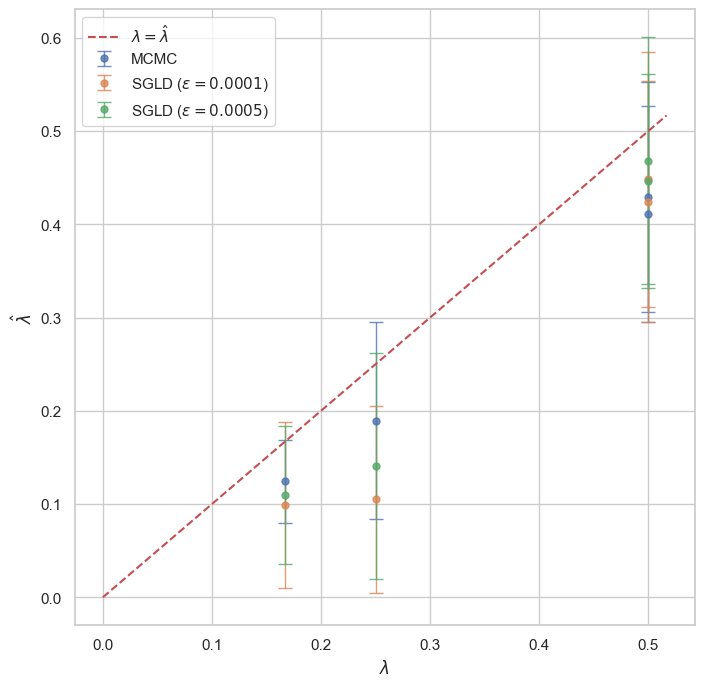

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
df = df_result[
    ["sampler_name", "monomial", "prior_monomial", "true_lambda", "lambdahat", "nu"]
].copy(deep=True)

mask = [x.startswith("uniform") for x in df["prior_monomial"]]
df = df[mask]
df = df.groupby(["sampler_name", "monomial", "prior_monomial"]).agg(["mean", "std"])
for sampler_name in df.index.get_level_values(0).unique():
    xvals = df.loc[sampler_name, "true_lambda"]["mean"]
    yvals = df.loc[sampler_name, "lambdahat"]["mean"]
    ystds = df.loc[sampler_name, "lambdahat"]["std"]
    ax.errorbar(xvals, yvals, yerr=ystds, 
                fmt='o', capsize=5, linestyle='None', markersize=5,
                elinewidth=1, alpha=0.8, label=sampler_name)

# ax.plot(xvals, yvals, "kx")
xmin, xmax = ax.get_xlim()
xrange = np.linspace(0, xmax, num=50)
ax.plot(xrange, xrange, "--", label="$\lambda=\hat{\lambda}$")
ax.legend()
ax.set_xlabel("$\lambda$")
ax.set_ylabel("$\hat{\lambda}$")

savefig_fn(fig, "toypotential_lambdahat_vs_lambda_monomialprior.png")
df
plt.show()

---
# Two Component Toy Potential
---
## Posterior concentration

Saving file at: ./images/paper/line_vs_flat_point_singular_potential.png


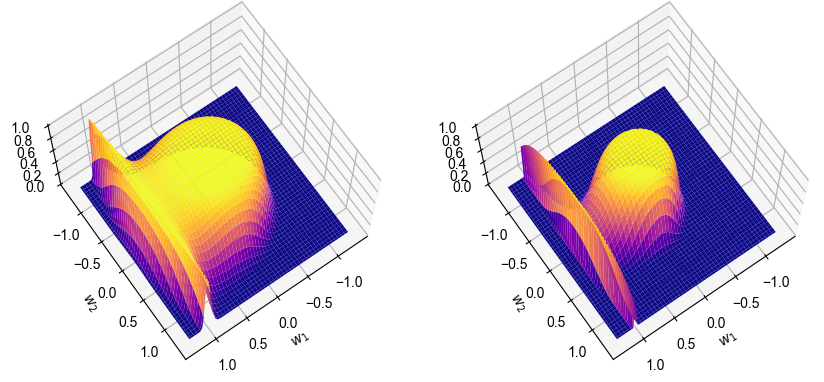

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib as mpl

# Define the function K(w1, w2)
def K(w1, w2):
    return (w1 - 1)**2 * (w1**2 + w2**2)**4
    
# Define the function exp(-nK(w1, w2))
def exp_nK(w1, w2, n):
    return np.exp(-n * K(w1, w2))

# Define the range of w values
a = 1.3
b = 1.3
w1 = np.linspace(-a, a, 100)
w2 = np.linspace(-b, b, 100)
W1, W2 = np.meshgrid(w1, w2)


with plt.style.context(["default", "_mpl-gallery-nogrid"]):
    fig = plt.figure(figsize=(8, 8))
    ns = [5, 100]
    for i, n in enumerate(ns):
        ax = fig.add_subplot(1, len(ns), i + 1, projection='3d')
        ax.plot_surface(W1, W2, exp_nK(W1, W2, n), cmap='plasma')
        ax.set_xlabel("$w_1$")
        ax.set_ylabel("$w_2$")
        # ax.set_title("$e^{-" + str(n) + "K(w_1, w_2)}$")
        ax.view_init(elev=70, azim=55)

savefig_fn(fig, "line_vs_flat_point_singular_potential.png")
plt.show()


## Histogram of two component potential experiments

Saving file at: ./images/paper/twocomponent_potential_histogram.png


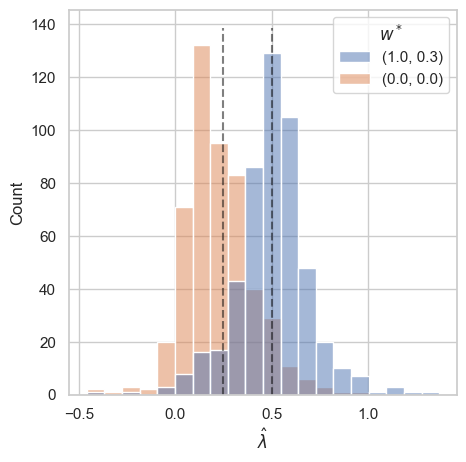

In [75]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_style("whitegrid")

# Load JSON file
RESULTDIR = "./outputs/two_component_potential/twocomp_20230807/"
result_files = [os.path.join(RESULTDIR, filename) for filename in os.listdir(RESULTDIR) if filename.endswith(".json")]
result_filepath = result_files[0]
with open(result_filepath, 'r') as f:
    df = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(df)
# df = df[df["lambdahat"] > 0]

# Convert 'w_init' lists to unique string representations
df['$w^*$'] = df['w_init'].apply(lambda x: tuple(x))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.histplot(data=df, x="lambdahat", hue="$w^*$", bins=20, ax=ax, hue_order=[(1.0, 0.3), (0.0, 0.0)])
ymin, ymax = ax.get_ylim()
ax.vlines([0.25, 0.5], ymin=ymin, ymax=ymax, alpha=0.5, linestyles="dashed", color="black")
ax.set_xlabel("$\hat{\lambda}$")
savefig_fn(fig, "twocomponent_potential_histogram.png")
plt.show()

## Sample paths

Running SGLD
Plotting
Running SGLD
Plotting
Running SGLD
Plotting


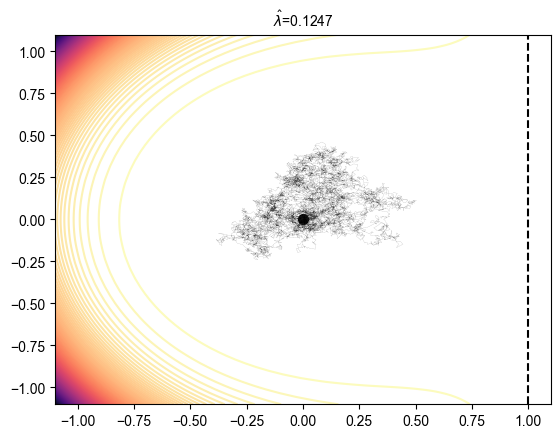

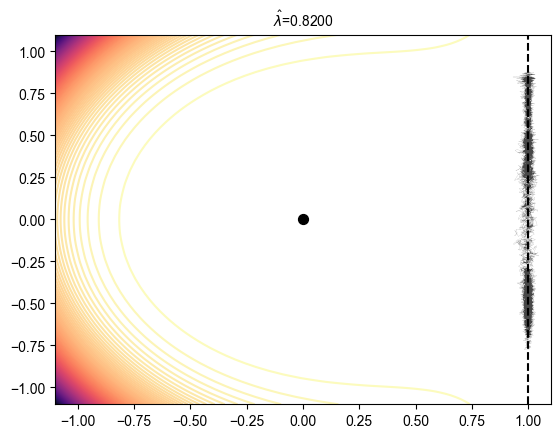

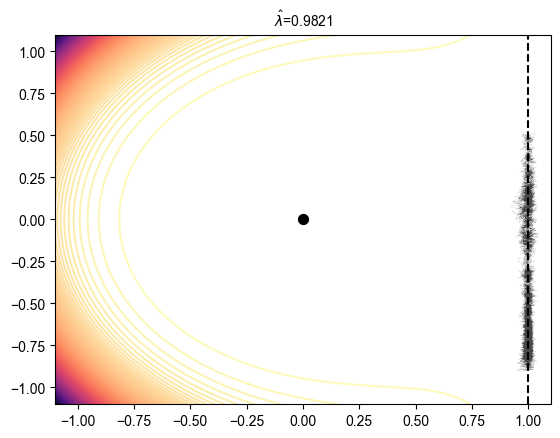

In [8]:
import jax
import jax.numpy as jnp
from jax import random
from jax.scipy.stats import norm
import numpy as np
import numpyro.distributions as dist
# import matplotlib.pyplot as plt

# Define the polynomial function
@jax.jit
def p(w):
    w1, w2 = w
    # return (w1 - 1) * (w1**2 + w2**2)**3
    # return (w1**3 - w2**2)**2
    # return w1 * w2**4
    return (w1 - 1) * (w1**2 + w2**2)**2

# Stochastic Gradient Langevin Dynamics
def SGLD_step(key, grad_log_posterior, w, epsilon):
    eta = random.normal(key, shape=w.shape) * jnp.sqrt(epsilon)
    return w + epsilon * grad_log_posterior(w) / 2 + eta

# Function to compute the log-likelihood of the observations given the parameters
@jax.jit
def log_likelihood(w, x, y, sigma):
    mu = p(w) * x
    return jnp.sum(norm.logpdf(y, loc=mu, scale=sigma))

# Function to compute the log-posterior
@jax.jit
def log_posterior(w, x, y, sigma, prior_mean, prior_sigma, itemp=1.0):
    loglikehood_val = log_likelihood(w, x, y, sigma) 
    priordist = dist.MultivariateNormal(loc=prior_mean, covariance_matrix=prior_sigma * jnp.eye(2))
    prior = jnp.sum(priordist.log_prob(w))
    return loglikehood_val * itemp + prior

# Function to run SGLD
def run_SGLD(grad_log_posterior_fn, w_init, epsilon, num_steps, key):
    w = w_init
    trajectory = [w]
    for i in range(num_steps):
        key, subkey = random.split(key)
        w = SGLD_step(subkey, grad_log_posterior_fn, w, epsilon)
        trajectory.append(w)
    return jnp.array(trajectory)

# w_init = np.random.rand(2)
sigma = 0.5
prior_sigma = 1.0
epsilon = 0.0001
num_steps = 10000
key = random.PRNGKey(42)

# Generate some data
N = 10000
true_w = jnp.array([0.0, 0.0])
key, subkey = random.split(key)
x = random.normal(key, shape=(N,))
y = 0 * x + sigma * random.normal(subkey, shape=(N,))


for w_init, seed in [((0.0, 0.0), 1), ((1.0, 0.3), 2), ((1.0, 0.3), 3)]:
    key = random.PRNGKey(seed)
    w_init = jnp.array(w_init) 
    # Run SGLD
    print("Running SGLD")
    itemp = 1 / jnp.log(N)
    # itemp = 10
    grad_log_posterior_fn = jax.jit(jax.grad(lambda w: log_posterior(w, x, y, sigma, w_init, prior_sigma, itemp=itemp)))
    trajectory = run_SGLD(grad_log_posterior_fn, w_init, epsilon, num_steps, key)

    # Plotting
    print("Plotting")
    val = np.max(np.abs(trajectory))
    val = np.max([1.1, val])
    w1_vals = jnp.linspace(-val, val, 100)
    w2_vals = jnp.linspace(-val, val, 100)

    W1, W2 = jnp.meshgrid(w1_vals, w2_vals)
    Z = jnp.array([[log_likelihood(jnp.array([w1, w2]), x, y, sigma) 
                    for w1 in w1_vals] 
                    for w2 in w2_vals]) / N
    with plt.style.context(["default"]):
        fig, ax = plt.subplots(1, 1)
        ax.contour(W1, W2, Z, levels=150, cmap='magma')
        ax.plot(trajectory[:, 0], trajectory[:, 1], 'k--', linewidth=0.1, markersize=0.1, alpha=0.8)
        # ax.scatter(trajectory[0, 0], trajectory[0, 1], c='red')
        # ax.scatter(trajectory[-1, 0], trajectory[-1, 1], c='blue')
        samples = trajectory
        hatlambda = (-np.mean([log_likelihood(w, x, y, sigma) for w in samples]) + log_likelihood([0, 0], x, y, sigma)) / np.log(N)

        symhatlambda = "$\hat{\lambda}$"
        ax.set_title(f"{symhatlambda}={hatlambda:.4f}", fontsize=10)
        ymin, ymax = ax.get_ylim()
        ax.vlines([1], ymin=ymin, ymax=ymax, linestyles="dashed", color="black")
        ax.scatter([0.0], [0.0], s=50, marker="o", color="black")
plt.show()

# Gamma effect on SGLD trajectory in normal crossing potential

INFO - sgld_toy2dpotential_experiment - Running command 'run_experiment'
INFO - sgld_toy2dpotential_experiment - Started run with ID "471"
INFO - jax._src.xla_bridge - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO - jax._src.xla_bridge - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO - jax._src.xla_bridge - Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


sgld, (1, 1), None, itemp:0.1448, lambdahat:0.0247, lambda:0.5000, nu:1.2356798648834229
sgld, (1, 2), None, itemp:0.1448, lambdahat:-0.0002, lambda:0.2500, nu:0.06268206238746643
sgld, (1, 3), None, itemp:0.1448, lambdahat:0.0000, lambda:0.1667, nu:0.0016073370352387428
sgld, (2, 2), None, itemp:0.1448, lambdahat:-0.0019, lambda:0.2500, nu:0.0012845080345869064
sgld, (2, 3), None, itemp:0.1448, lambdahat:0.0001, lambda:0.1667, nu:5.564887396758422e-05
sgld, (3, 3), None, itemp:0.1448, lambdahat:-0.0000, lambda:0.1667, nu:1.3247016568129766e-06


INFO - sgld_toy2dpotential_experiment - Completed after 0:00:48


Figure saved at: ./images/paper/posterior_sgld_n1000_eps0.001_sigmap0.01_chain10000_rngseed0.png


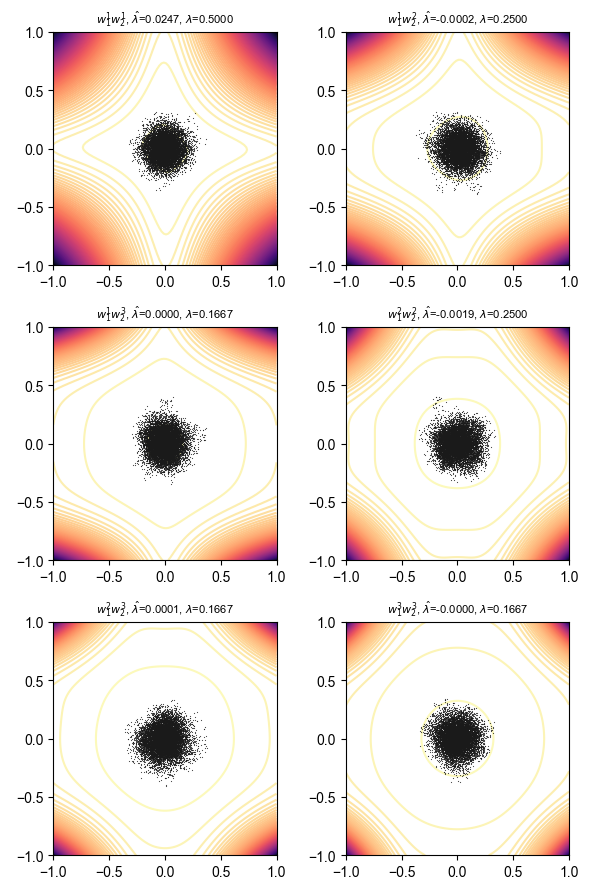

In [3]:
from sgld_2d_normalcrossing import ex
monomial_prior_spec = tuple(
    [((i, j), None) for i in range(1, 4) for j in range(i, 4)]
)

config = {
    "outputdir": IMAGEDIR,
    "sampler_type": "sgld",
    "num_training_data": 1000, 
    "sigma": 0.5, 
    "prior_sigma": 0.01, 
    "epsilon": 0.001, 
    "monomial_prior_spec": monomial_prior_spec,
    "num_steps": 10000, 
    "seed": 0, 
    "no_plot": False
}
with plt.style.context(["default"]):
    ex.run(config_updates=config, meta_info={"expt_name": "test_run"})
plt.show()